## Librerias Necesarias

In [35]:

import numpy as np
import CPMP_attention_model as cpmp_att
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

## Funciones para entrenamiento y predicciones

In [36]:
#************ | expand_dims_cpmp() | **************#
# El proposito de esta función es expandir las     #
# dimensiones de un estado menor para que pueda    #
# ser predicho un por modelo para un estado mayor. #
#                                                  #
# Input:                                           #
#     - data: Lista de matrices con todos los      #
#             estados.                             #
#     - labels: lista de posibles stacks de origen #
#               o destino.                         #
#     - stacks: Cantidad de stacks permitidos por  #    
#               el modelo.                         #
#     - height: Altura máxima de los stacks        #
#               permitidos por el modelo.          #
#                                                  #
# Output:                                          #
#      Retona un arreglo de los datos              #
#      redimensionados con sus respectivos labels. #
def expand_dims_cpmp(data, labels, stacks, height):
    size = data.shape[1]
    tuple_data = zip(data, labels)
    data_2 = []
    labels_2 = []

    for matrix, label in tuple_data:
        matrix = matrix.tolist()
        label = label.tolist()
        for i in range(stacks - size):
            matrix.append([1] + [1 for n in range(height)])
            label.append(0)

        data_2.append(matrix)
        labels_2.append(label)

    return np.array(data_2), np.array(labels_2)

In [37]:
#************* | is_equal() | **************#
# El proposito de esta función es verificar #
# si los datos ingresados en dos arreglos   #
# son exactamente iguales independiente de  #
# su posición.                              #
#                                           #
# Input:                                    #
#     - array1: Primer arreglo que se       #
#               desea comparar.             #
#     - array2: Segundo arreglo que se      #
#               desea comparar.             #
# Output:                                   #
#     Retorna true en el caso de tener      #
#     cada dato exactamente igual o         #
#     False en caso contrario.              #
def is_equal(array1, array2):
    size = len(array1)
    cant = 0
    array1.sort()
    array2.sort()

    for i in range(size):
        if array1[i] == array2[i]:
            cant += 1

    if cant == size: return True

    return False

In [38]:
#***************** | precision() | ***************#
# El proposito de esta función es verificar si    #
# los valores predichos por una red neuronal son  #
# correctos o no.                                 #
#                                                 #
# Input:                                          #
#     - y_predict: Valores predichos por el       #
#                  mecanismo de machine learning. #
#     - y_test: Valores reales de los casos       #
#               predichos.                        #
# Output:                                         #
#     Retorna una proporción entre los valores    #
#     predichos correctamente sobre la cantidad   #
#     de datos.                                   #
def precision(y_predict, y_test):
    size = len(y_predict)
    predict = 0

    for i in range(size):
        if np.argmax(y_predict[i]) == np.argmax(y_test[i]):
            predict += 1
    
    return predict / size

In [39]:
#************** | precision_for_multiclass() | ***************#
# El proposito de esta función es verificar si los valores    #
# predichos por un mecanismo de machine learning para         #
# clasificación multiclase están correctos o no.              #
#                                                             # 
# Input:                                                      #
#     - y_predict: Valores predichos por el mecanismo de      #
#                  machine learning.                          #
#     - y_test: Valores reales de cada caso.                  #
# Output:                                                     #
#     Retorna una proporción entre los valores predichos      #
#     correctamente sobre la cantidad total de casos.         #
def cosine_Similarity(y_predict, y_test):
    size = len(y_predict)
    suma = 0

    for i in range(size):
        result = np.dot(y_predict[i], y_test[i]) / (np.linalg.norm(y_predict[i]) * np.linalg.norm(y_test[i]))
        suma += result
    
    return suma / size

## Funciones para cargar y guardar data

In [40]:
#************** | load_data() | ************#
# El proposito de esta función es cargar    #
# los datos almacenados en un csv para el   #
# entrenamiento de la red neuronal.         #
#                                           #
# Input:                                    #
#     - name: Nombre del archivo con su     #
#             dirección correspondiente     #
#             sin el .csv.                  #
#                                           #
# Output:                                   #
#      Retorna 3 arreglos, el primero       #
#      corresponde a una lista de estados,  #
#      el segundo a una lista de labels     #
#      de stacks de origen y por último una #
#      lista de posibles stacks de destino. #
def load_data(name):
    data = []
    labels_1 = []
    labels_2 = []

    with open(name + '.csv', 'r') as archivo:
        total = int(archivo.readline().split(':')[1])
        line = archivo.readline().split(':')
        size_stacks = int(line[1].split(',')[0])
        size_height = int(line[2])
        archivo.readline()

        for i in range(total):
            matrix = archivo.readline().split(':')[1].split(',')
            matrix = np.array(matrix, dtype= float)
            matrix = np.reshape(matrix, (size_stacks, size_height))

            label_1 = archivo.readline().split(':')[1].split(',')
            label_1 = np.array(label_1, dtype= float)
            label_2 = archivo.readline().split(':')[1].split(',')
            label_2 = np.array(label_2, dtype= float)

            data.append(matrix)
            labels_1.append(label_1)
            labels_2.append(label_2)

            archivo.readline()

    return np.stack(data), np.stack(labels_1), np.stack(labels_2)

In [41]:
def load_data_2(name: str) -> tuple:
    data = []
    labels = []

    with open(name + '.csv', 'r') as archivo:
        total = int(archivo.readline().split(':')[1])
        line = archivo.readline().split(':')
        size_stacks = int(line[1].split(',')[0])
        size_height = int(line[2])
        archivo.readline()

        for i in range(total):
            matrix = archivo.readline().split(':')[1].split(',')
            matrix = np.array(matrix, dtype= float)
            matrix = np.reshape(matrix, (size_stacks, size_height))

            label_1 = archivo.readline().split(':')[1].split(',')
            label_1 = np.array(label_1, dtype= float)

            data.append(matrix)
            labels.append(label_1)

            archivo.readline()

    return np.stack(data), np.stack(labels)

In [42]:
def load_data_multi(name):
    data = []
    data_2 = []
    labels_1 = []
    labels_2 = []

    with open(name + '_so.csv', 'r') as archivo:
        total = int(archivo.readline().split(':')[1])
        line = archivo.readline().split(':')
        size_stacks = int(line[1].split(',')[0])
        size_height = int(line[2])
        archivo.readline()

        for i in range(total):
            matrix = archivo.readline().split(':')[1].split(',')
            matrix = np.array(matrix, dtype= float)
            matrix = np.reshape(matrix, (size_stacks, size_height))

            label_1 = archivo.readline().split(':')[1].split(',')
            label_1 = np.array(label_1, dtype= float)

            data.append(matrix)
            labels_1.append(label_1)

            archivo.readline()

    with open(name + '_sd.csv', 'r') as archivo:
        total = int(archivo.readline().split(':')[1])
        line = archivo.readline().split(':')
        size_stacks = int(line[1].split(',')[0])
        size_height = int(line[2])
        archivo.readline()

        for i in range(total):
            matrix = archivo.readline().split(':')[1].split(',')
            matrix = np.array(matrix, dtype= float)
            matrix = np.reshape(matrix, (size_stacks, size_height))

            label_2 = archivo.readline().split(':')[1].split(',')
            label_2 = np.array(label_2, dtype= float)

            data_2.append(matrix)
            labels_2.append(label_2)

            archivo.readline()

    return np.stack(data), np.stack(data_2), np.stack(labels_1), np.stack(labels_2)

# Cargar Data

In [23]:
data_5x5, labels_5x5 = load_data_2('data/data_5x5_Multiple')

In [43]:
data_7x7, labels_7x7 = load_data_2('data/data_7x7_Multiple')

# Modelo con Varias Salidas

## Modelo 5x5

In [10]:
model_5x5_multi = cpmp_att.CPMP_attention_model()

In [11]:
model_5x5_multi.create_model(num_layer_attention_add= 2, heads= 5, S= 5, H= 5, optimizer= 'Adam')

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


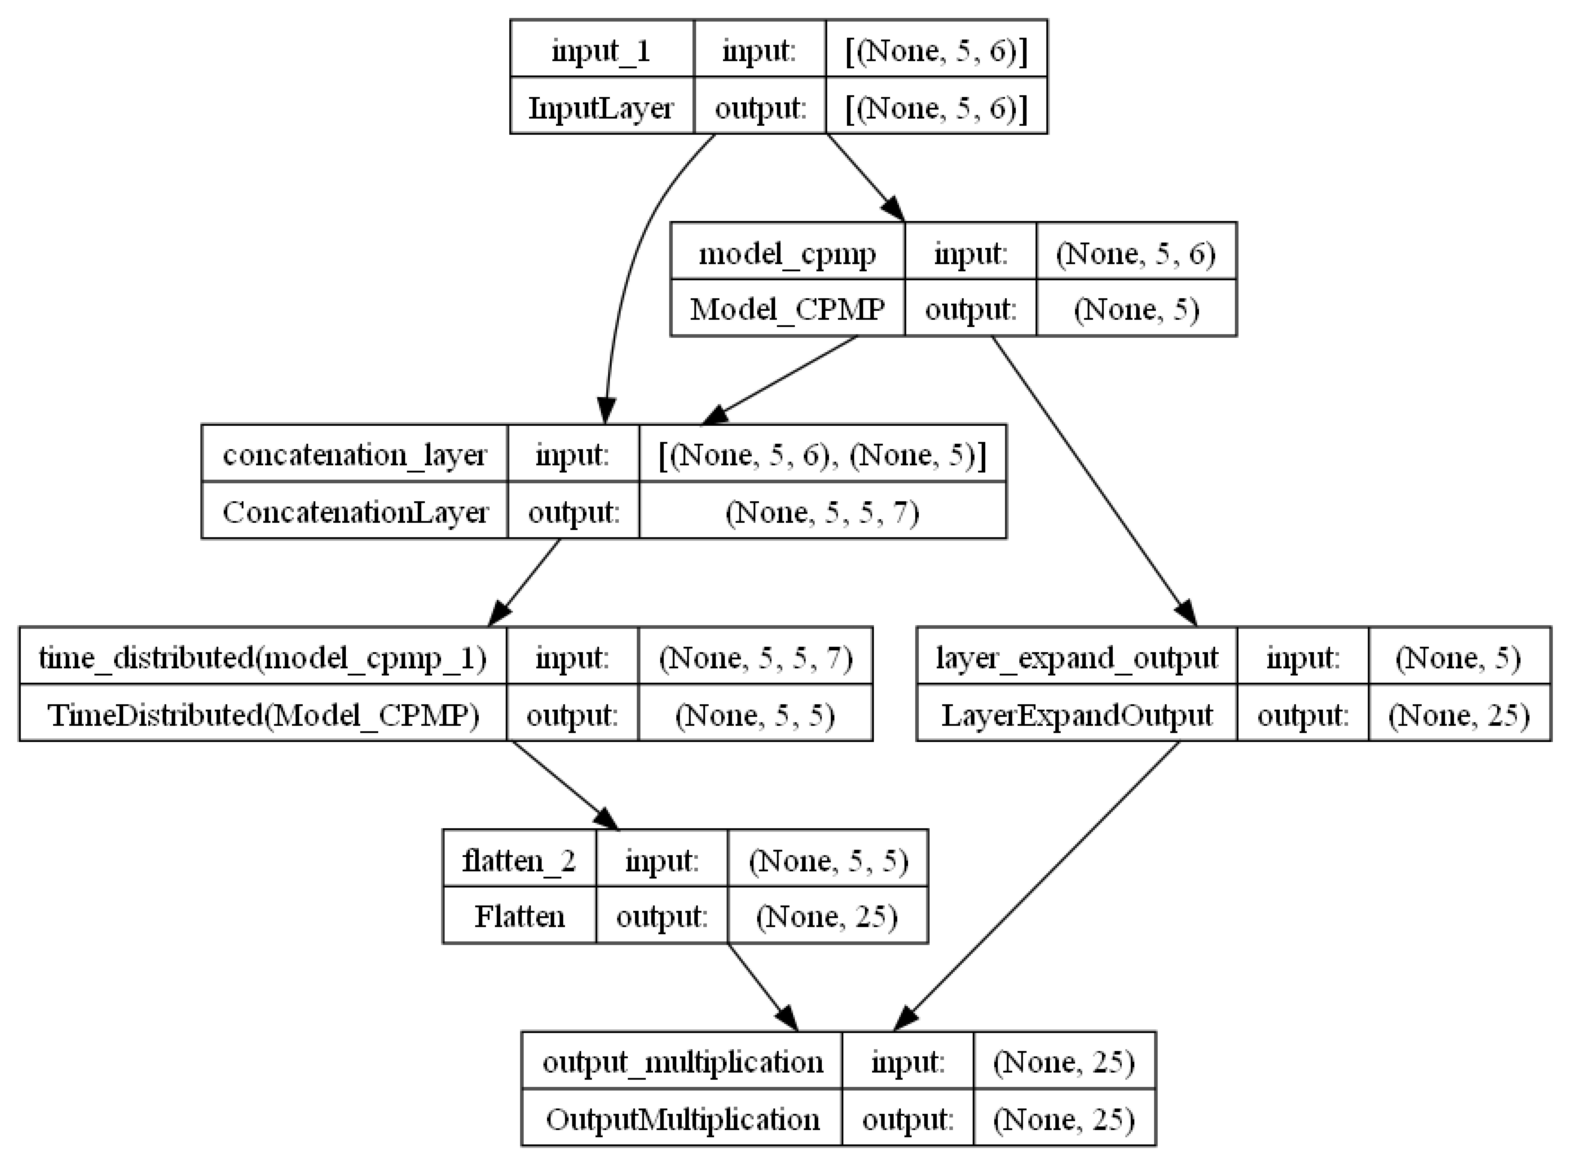

In [12]:
model_5x5_multi.plot_model(name= 'images_models/model_cpmp_multi')

### Entrenamiento

In [16]:
X_train_5x5, X_test_5x5, y_train_5x5, y_test_5x5 = train_test_split(data_5x5, labels_5x5, 
                                                                    test_size= 0.2, random_state= 42)

In [21]:
records = model_5x5_multi.fit(X_train_5x5, y_train_5x5, epochs= 50, verbose= True)

Epoch 1/50
6250/6250 [==============================] - 57s 8ms/step - loss: 0.1216 - mae: 0.0765 - mse: 0.0373
Epoch 2/50
6250/6250 [==============================] - 51s 8ms/step - loss: 0.0810 - mae: 0.0518 - mse: 0.0255
Epoch 3/50
6250/6250 [==============================] - 51s 8ms/step - loss: 0.0706 - mae: 0.0452 - mse: 0.0223
Epoch 4/50
6250/6250 [==============================] - 49s 8ms/step - loss: 0.0640 - mae: 0.0410 - mse: 0.0202
Epoch 5/50
6250/6250 [==============================] - 49s 8ms/step - loss: 0.0604 - mae: 0.0387 - mse: 0.0191
Epoch 6/50
6250/6250 [==============================] - 49s 8ms/step - loss: 0.0578 - mae: 0.0370 - mse: 0.0183
Epoch 7/50
6250/6250 [==============================] - 53s 9ms/step - loss: 0.0562 - mae: 0.0359 - mse: 0.0178
Epoch 8/50
6250/6250 [==============================] - 52s 8ms/step - loss: 0.0555 - mae: 0.0354 - mse: 0.0175
Epoch 9/50
6250/6250 [==============================] - 51s 8ms/step - loss: 0.0545 - mae: 0.0349 - mse:

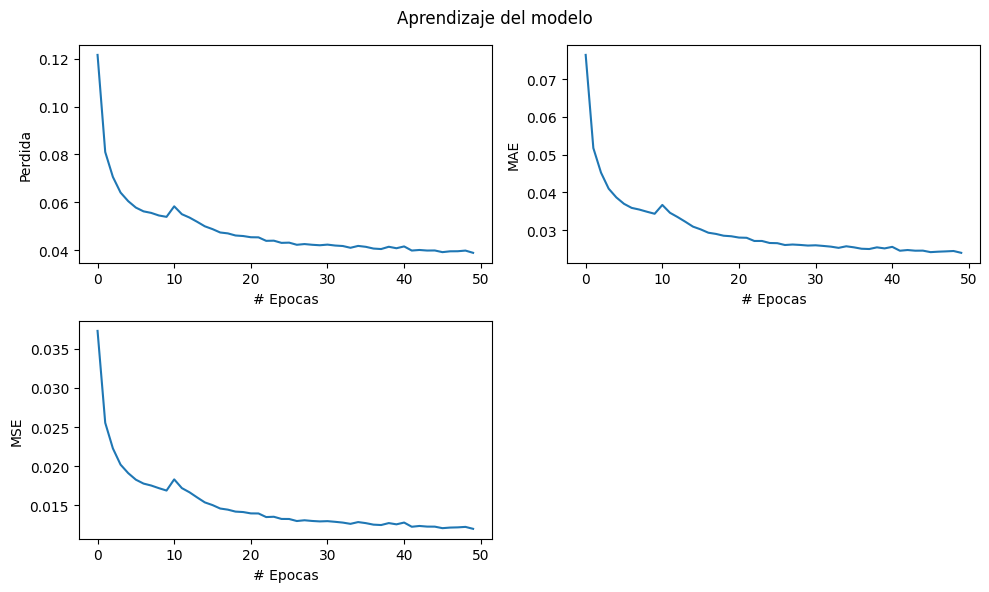

In [24]:
plt.figure(figsize= (10, 6))

plt.subplot(2, 2, 1)
plt.xlabel("# Epocas")
plt.ylabel("Perdida")
plt.plot(records.history['loss'])

plt.subplot(2, 2, 2)
plt.xlabel("# Epocas")
plt.ylabel("MAE")
plt.plot(records.history['mae'])

plt.subplot(2, 2, 3)
plt.xlabel("# Epocas")
plt.ylabel("MSE")
plt.plot(records.history['mse'])

plt.suptitle('Aprendizaje del modelo')
plt.tight_layout()
plt.show()

In [22]:
predict = model_5x5_multi.predict(X_test_5x5)

1563/1563 [==============================] - 11s 7ms/step


In [23]:
results = cosine_Similarity(predict, y_test_5x5)


print(f'Precisión del modelo: {round(results * 100, 3)}%')

Precisión del modelo: 94.512%


## Modelo 7x7

In [44]:
model_7x7_multi = cpmp_att.CPMP_attention_model()

In [45]:
model_7x7_multi.create_model(num_layer_attention_add= 2, heads= 5, S= 7, H= 7, optimizer= 'Adam')

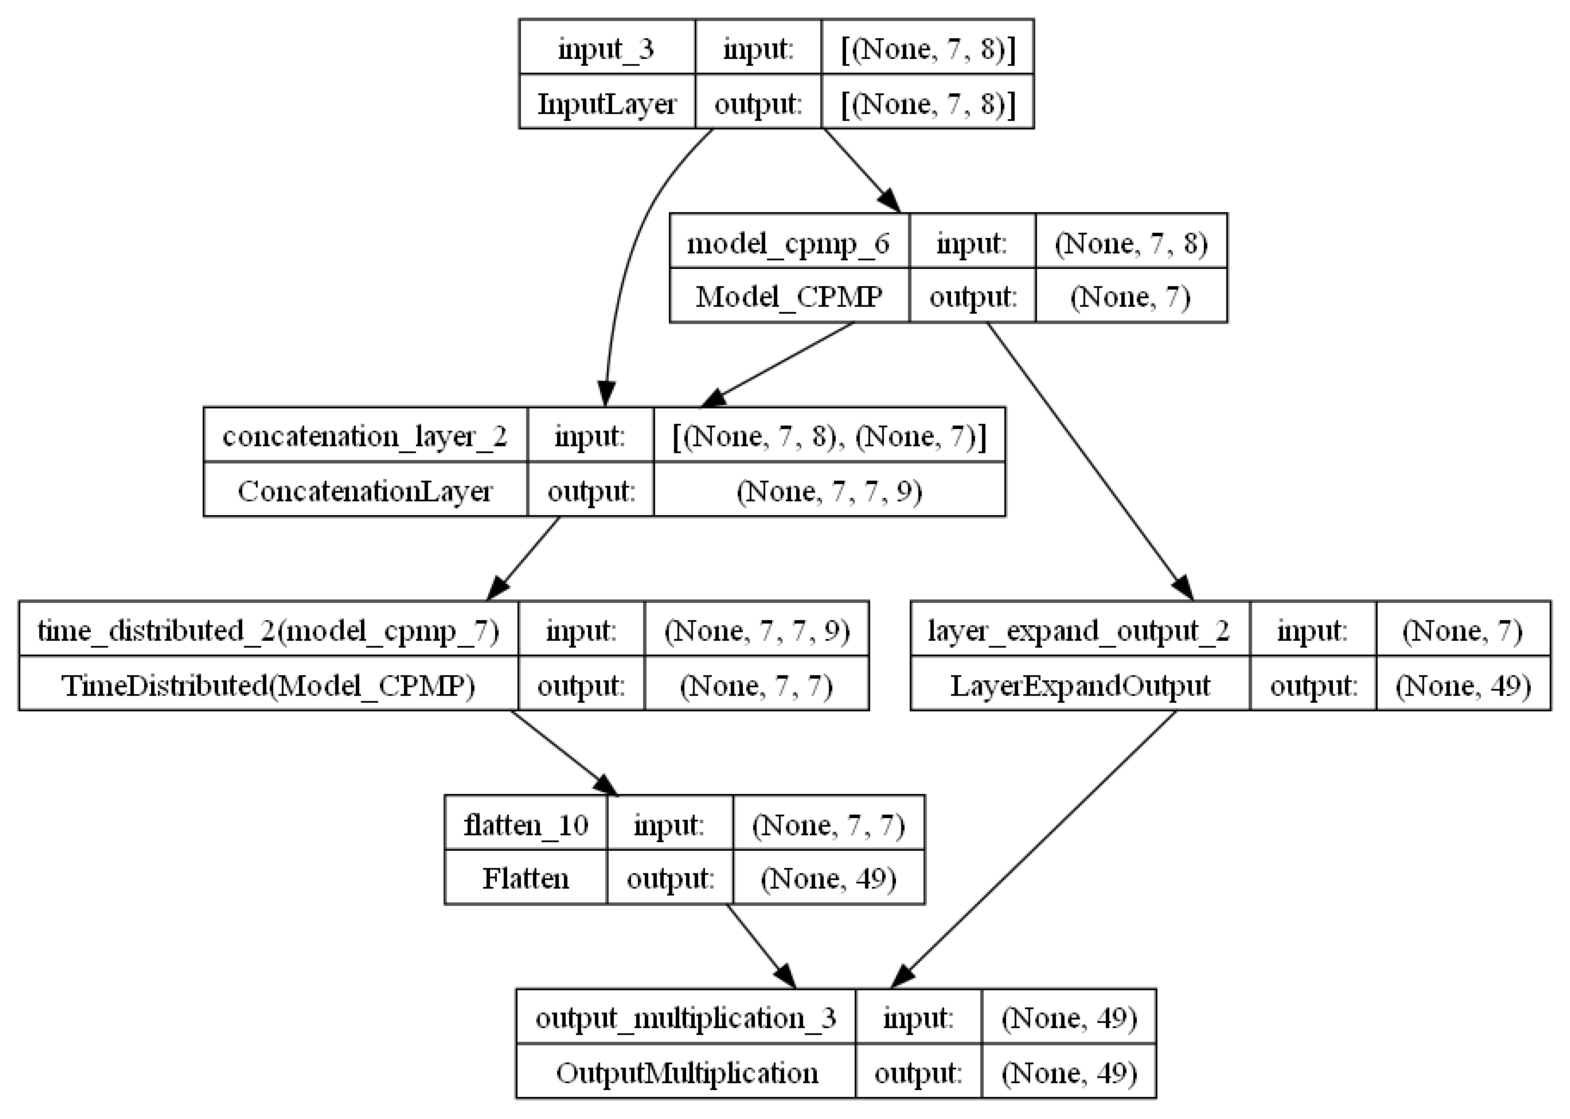

In [46]:
model_7x7_multi.plot_model(name= 'images_models/model_cpmp_multi')

### Entrenamiento

In [47]:
X_train_7x7, X_test_7x7, y_train_7x7, y_test_7x7 = train_test_split(data_7x7, labels_7x7, 
                                                                    test_size= 0.2, random_state= 42)

In [49]:
records = model_7x7_multi.fit(X_train_7x7, y_train_7x7, epochs= 50, verbose= True)

Epoch 1/50
2500/2500 [==============================] - 45s 14ms/step - loss: 0.1254 - mae: 0.0702 - mse: 0.0340
Epoch 2/50
2500/2500 [==============================] - 34s 13ms/step - loss: 0.0682 - mae: 0.0424 - mse: 0.0210
Epoch 3/50
2500/2500 [==============================] - 32s 13ms/step - loss: 0.0580 - mae: 0.0355 - mse: 0.0177
Epoch 4/50
2500/2500 [==============================] - 38s 15ms/step - loss: 0.0551 - mae: 0.0337 - mse: 0.0168
Epoch 5/50
2500/2500 [==============================] - 38s 15ms/step - loss: 0.0535 - mae: 0.0327 - mse: 0.0163
Epoch 6/50
2500/2500 [==============================] - 43s 17ms/step - loss: 0.0521 - mae: 0.0319 - mse: 0.0159
Epoch 7/50
2500/2500 [==============================] - 54s 22ms/step - loss: 0.0513 - mae: 0.0314 - mse: 0.0157
Epoch 8/50
2500/2500 [==============================] - 46s 19ms/step - loss: 0.0507 - mae: 0.0311 - mse: 0.0155
Epoch 9/50
2500/2500 [==============================] - 56s 23ms/step - loss: 0.0507 - mae: 0.03

In [50]:
predict = model_7x7_multi.predict(X_test_7x7)

625/625 [==============================] - 5s 6ms/step


In [51]:
results = cosine_Similarity(predict, y_test_7x7)

print(f'Precisión del modelo: {round(results * 100, 3)}%')

Precisión del modelo: 90.463%


In [52]:
model_7x7_multi.save_model('models/model_cpmp_7x7.h5')

c:\Users\matia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
